In [1]:
import os
import sys
from pathlib import Path

In [2]:
current_path = %pwd
current_path = Path(current_path)
sys.path.insert(0, str(current_path.parent))

In [3]:
sys.path

['/home/amaevskiy/TPC/TPC-FastSim',
 '/usr/lib/python36.zip',
 '/usr/lib/python3.6',
 '/usr/lib/python3.6/lib-dynload',
 '',
 '/home/amaevskiy/TPC/TPC-FastSim/.local/lib/python3.6/site-packages',
 '/usr/local/lib/python3.6/dist-packages',
 '/usr/lib/python3/dist-packages',
 '/usr/local/lib/python3.6/dist-packages/IPython/extensions',
 '/home/amaevskiy/TPC/TPC-FastSim/.ipython']

In [4]:
from itertools import cycle

#import tensorflow as tf
#print(tf.__version__)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

from IPython.display import HTML, clear_output
from matplotlib.animation import FuncAnimation

from sklearn.model_selection import train_test_split

from tqdm import trange

In [5]:
from data import preprocessing
preprocessing._VERSION = 'data_v4'

In [6]:
preprocessing._THIS_PATH

PosixPath('/home/amaevskiy/TPC/TPC-FastSim/data')

In [7]:
# preprocessing.raw_to_csv()

In [8]:
df = pd.read_csv(preprocessing._THIS_PATH.joinpath('data_v4', 'csv', 'digits.csv'))
print(df.dtypes)

evtId               int64
ipad                int64
itime               int64
amp               float64
crossing_angle    float64
dip_angle         float64
drift_length      float64
pad_coordinate    float64
dtype: object


In [9]:
df.describe()

,evtId,ipad,itime,amp,crossing_angle,dip_angle,drift_length,pad_coordinate
count,544512.000000,544512.000000,544512.000000,544512.000000,544512.000000,544512.000000,544512.000000,544512.000000
mean,9996.533792,43.190844,172.690677,243.329983,-0.060467,-0.534112,172.691818,43.190927
std,5767.153626,1.540470,72.611189,638.803050,11.693003,36.661121,72.577750,1.152119
min,0.000000,39.000000,31.000000,1.000000,-20.000000,-59.985000,35.878000,41.192000
25%,5008.000000,42.000000,111.000000,7.364000,-10.358000,-33.862000,110.722000,42.205000
50%,10000.000000,43.000000,177.000000,46.460000,-0.071000,-0.666000,177.216000,43.175000
75%,14984.000000,44.000000,236.000000,260.600000,10.223000,32.656000,235.991000,44.194000
max,19999.000000,48.000000,296.000000,39990.000000,20.099000,59.993000,290.405000,45.192000


In [10]:
(df.drift_length % 1).describe()

count    544512.000000
mean          0.499113
std           0.288775
min           0.000000
25%           0.248000
50%           0.498000
75%           0.749000
max           0.999000
Name: drift_length, dtype: float64

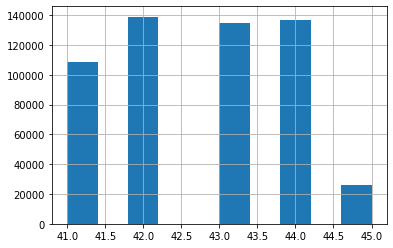

In [11]:
df.pad_coordinate.astype(int).hist();

In [11]:
# import tensorflow as tf

In [12]:
# x = tf.convert_to_tensor([3.45, -5.99, 3.25])
# x % 1

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([0.45000005, 0.01000023, 0.25      ], dtype=float32)>

# Explore the data a little

In [12]:
mean_signal = (
    df.groupby(['itime', 'ipad'])['amp'].sum()
    / len(df.groupby('evtId'))
).reset_index()

In [13]:
mean_signal['itime_n'] = mean_signal.itime - mean_signal.itime.min()
mean_signal['ipad_n' ] = mean_signal.ipad  - mean_signal.ipad .min()

In [14]:
ntime = mean_signal.itime.max() - mean_signal.itime.min() + 1
npad  = mean_signal.ipad .max() - mean_signal.ipad .min() + 1

mean_signal_matrix = np.zeros(dtype=float, shape=(npad, ntime))
mean_signal_matrix[tuple(mean_signal[['ipad_n', 'itime_n']].values.T)] = mean_signal.amp.values

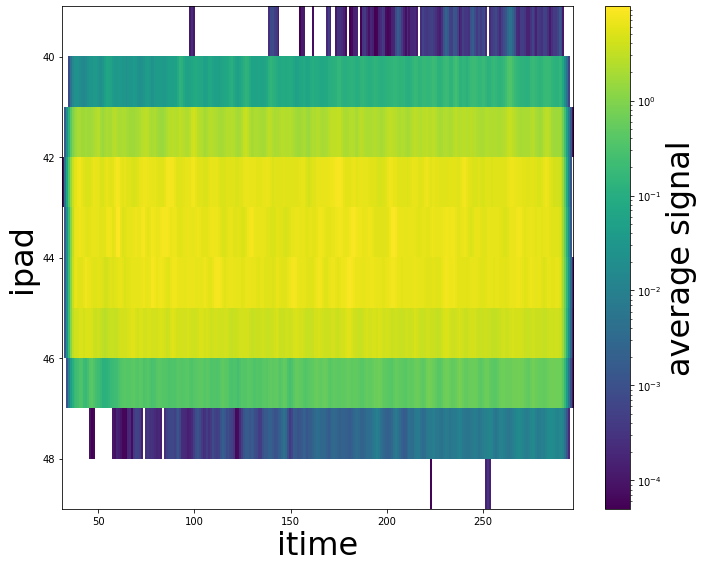

In [15]:
plt.figure(figsize=(10, 8))
img = plt.imshow(mean_signal_matrix, aspect='auto',
           extent=(
               mean_signal.itime.min()    , mean_signal.itime.max() + 1,
               mean_signal.ipad .max() + 1, mean_signal.ipad .min()    ,
           ),
           norm=LogNorm())
plt.colorbar(img).set_label("average signal", fontsize=32)
plt.xlabel('itime', fontsize=32)
plt.ylabel('ipad', fontsize=32)
plt.tight_layout();

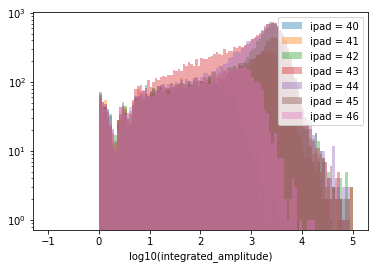

In [16]:
for i in range(40, 47):
  bins = np.linspace(-1, 5, 121)
  plt.hist(np.log10(
              ((df.loc[(df.ipad == i)]).groupby(['evtId', 'ipad'])['amp'].sum()).values
           ),
           bins=bins, histtype='stepfilled', alpha=0.4, label='ipad = {}'.format(i));
plt.legend();
plt.yscale('log')
plt.xlabel('log10(integrated_amplitude)');


# Transform the data

In [34]:
pad_range = (-3, 5)
time_range = (-9, 9)
data, features = preprocessing.read_csv_2d(
    pad_range=pad_range, time_range=time_range
)

In [36]:
data.shape, features.shape

((20000, 8, 18), (20000, 4))

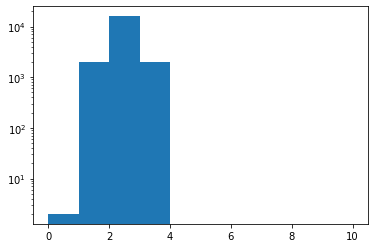

In [37]:
plt.hist((data == 0).all(axis=-1).argmin(axis=-1), bins=range(11))
plt.yscale('log');

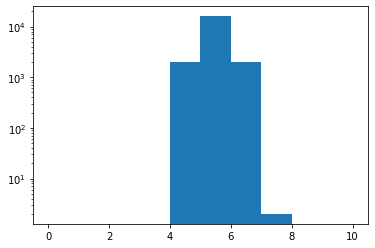

In [39]:
plt.hist(data.shape[1] - 1 - (data == 0).all(axis=-1)[:,::-1].argmin(axis=-1), bins=range(11))
plt.yscale('log');

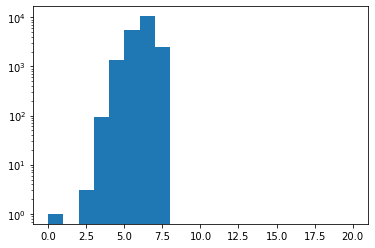

In [40]:
plt.hist((data == 0).all(axis=1).argmin(axis=-1), bins=range(21))
plt.yscale('log');

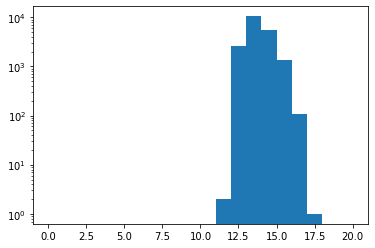

In [41]:
plt.hist(data.shape[-1] - 1 - (data == 0).all(axis=1)[...,::-1].argmin(axis=-1), bins=range(21))
plt.yscale('log');

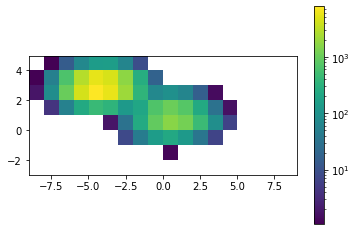

In [44]:
plt.colorbar(plt.imshow(
    data[(data == 0).all(axis=1).argmin(axis=-1).argmin()],
    extent=(*time_range, *pad_range), norm=LogNorm()
));

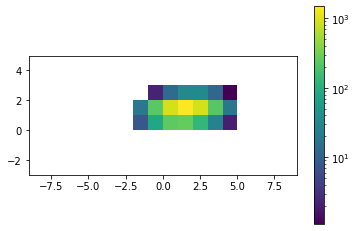

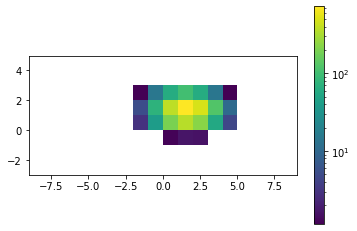

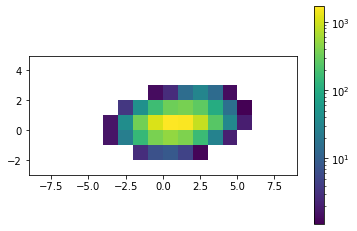

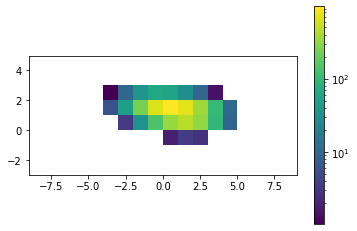

In [43]:
for i in [0, 100, 1000, 3000]:
    fig, ax = plt.subplots()
    im = ax.imshow(data[i, ::-1], extent=(*time_range, *pad_range), norm=LogNorm())
    plt.colorbar(im);

In [45]:
from metrics import get_val_metric_v, _METRIC_NAMES

In [46]:
metric = get_val_metric_v(data)

In [47]:
print(metric.shape)
print(_METRIC_NAMES)

(20000, 6)
['Mean0', 'Mean1', 'Sigma0^2', 'Sigma1^2', 'Cov01', 'Sum']


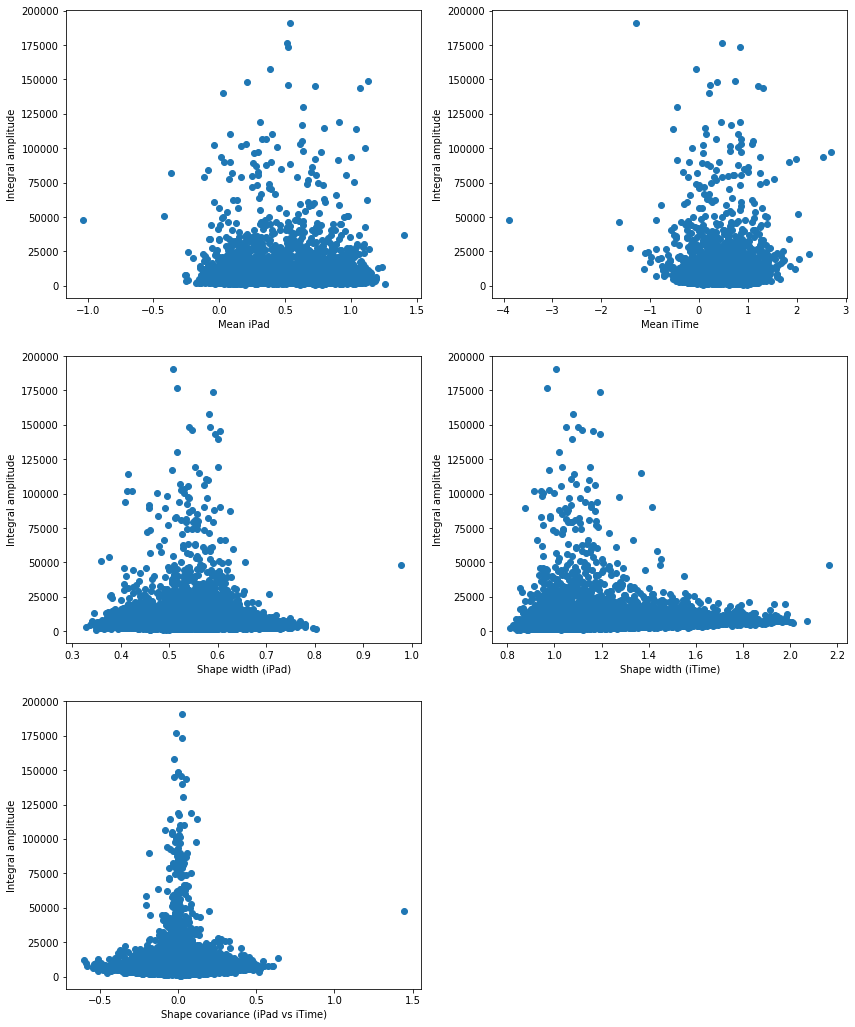

In [48]:
plt.figure(figsize=(14, 18))

plt.subplot(3, 2, 1)
plt.scatter(metric[:,_METRIC_NAMES.index('Mean0')] + pad_range[0], metric[:,_METRIC_NAMES.index('Sum')])
plt.xlabel('Mean iPad')
plt.ylabel('Integral amplitude')

plt.subplot(3, 2, 2)
plt.scatter(metric[:,_METRIC_NAMES.index('Mean1')] + time_range[0], metric[:,_METRIC_NAMES.index('Sum')])
plt.xlabel('Mean iTime');
plt.ylabel('Integral amplitude')

plt.subplot(3, 2, 3)
plt.scatter(metric[:,_METRIC_NAMES.index('Sigma0^2')]**0.5, metric[:,_METRIC_NAMES.index('Sum')])
plt.xlabel('Shape width (iPad)');
plt.ylabel('Integral amplitude')

plt.subplot(3, 2, 4)
plt.scatter(metric[:,_METRIC_NAMES.index('Sigma1^2')]**0.5, metric[:,_METRIC_NAMES.index('Sum')])
plt.xlabel('Shape width (iTime)');
plt.ylabel('Integral amplitude')

plt.subplot(3, 2, 5)
plt.scatter(metric[:,_METRIC_NAMES.index('Cov01')], metric[:,_METRIC_NAMES.index('Sum')])
plt.xlabel('Shape covariance (iPad vs iTime)');
plt.ylabel('Integral amplitude');

In [49]:
_METRIC_NAMES

['Mean0', 'Mean1', 'Sigma0^2', 'Sigma1^2', 'Cov01', 'Sum']

In [54]:
features.shape

(20000, 4)

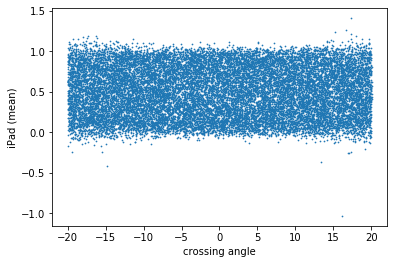

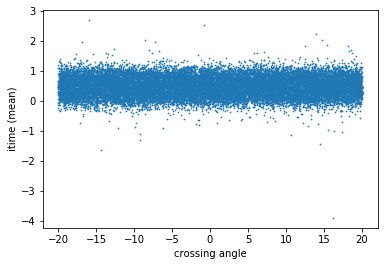

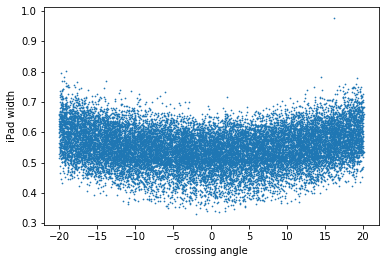

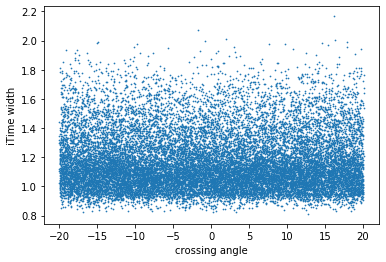

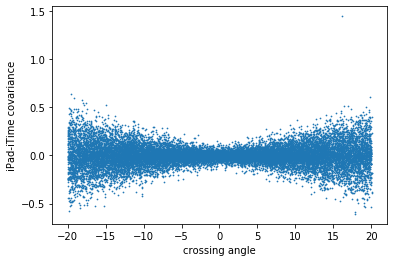

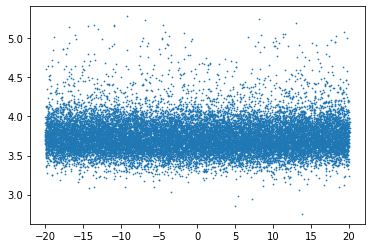

In [58]:
plt.figure();
plt.scatter(features[:,0], metric[:,0] + pad_range[0], s=0.5);
plt.xlabel("crossing angle")
plt.ylabel("iPad (mean)")

plt.figure();
plt.scatter(features[:,0], metric[:,1] + time_range[0], s=0.5);
plt.xlabel('crossing angle')
plt.ylabel("itime (mean)");

plt.figure();
plt.scatter(features[:,0], metric[:,2]**0.5, s=0.5);
plt.xlabel("crossing angle")
plt.ylabel("iPad width")

plt.figure();
plt.scatter(features[:,0], metric[:,3]**0.5, s=0.5);
plt.xlabel("crossing angle")
plt.ylabel("iTime width")


plt.figure();
plt.scatter(features[:,0], metric[:,4], s=0.5);
plt.xlabel("crossing angle")
plt.ylabel("iPad-iTime covariance")


plt.figure();
plt.scatter(features[:,0], np.log10(metric[:,5]), s=0.5);

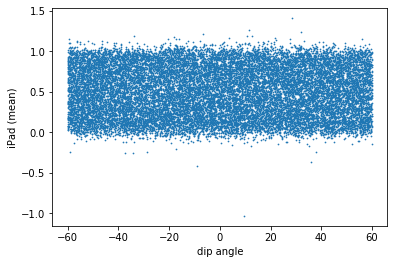

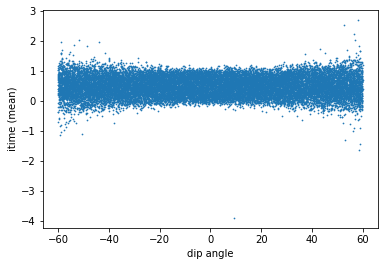

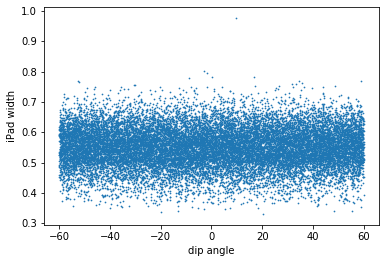

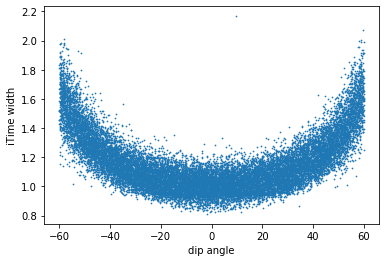

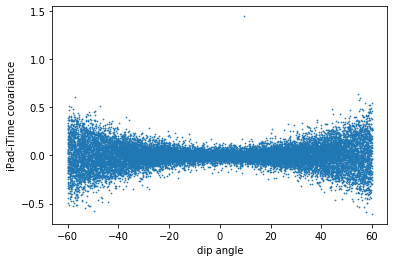

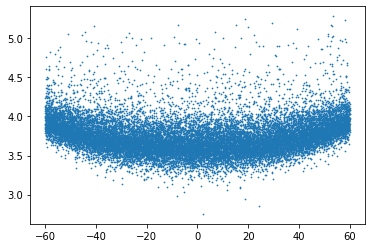

In [51]:
plt.figure();
plt.scatter(features[:,1], metric[:,0] + pad_range[0], s=0.5);
plt.xlabel("dip angle")
plt.ylabel("iPad (mean)")

plt.figure();
plt.scatter(features[:,1], metric[:,1] + time_range[0], s=0.5);
plt.xlabel('dip angle')
plt.ylabel("itime (mean)");

plt.figure();
plt.scatter(features[:,1], metric[:,2]**0.5, s=0.5);
plt.xlabel("dip angle")
plt.ylabel("iPad width")

plt.figure();
plt.scatter(features[:,1], metric[:,3]**0.5, s=0.5);
plt.xlabel("dip angle")
plt.ylabel("iTime width")


plt.figure();
plt.scatter(features[:,1], metric[:,4], s=0.5);
plt.xlabel("dip angle")
plt.ylabel("iPad-iTime covariance")


plt.figure();
plt.scatter(features[:,1], np.log10(metric[:,5]), s=0.5);

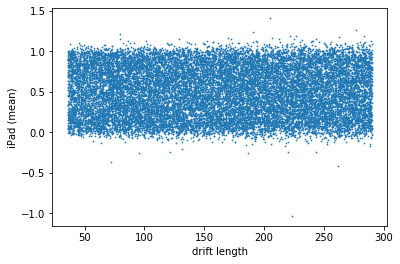

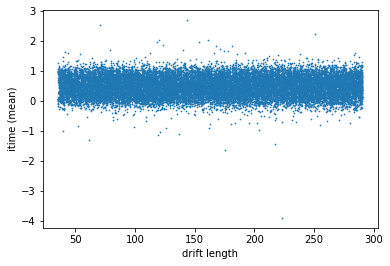

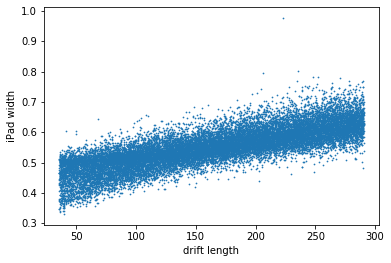

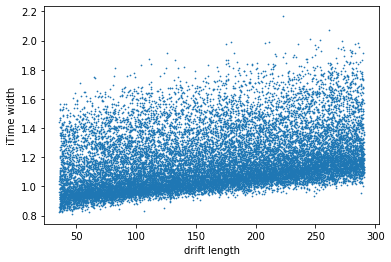

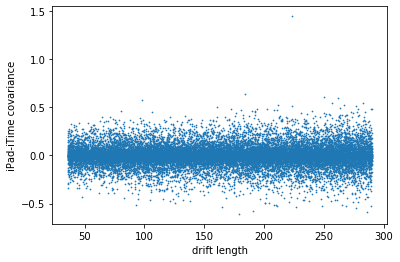

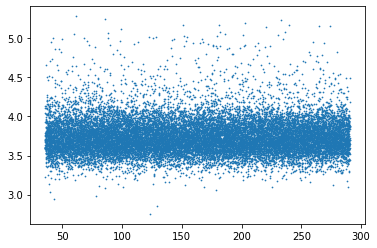

In [59]:
plt.figure();
plt.scatter(features[:,2], metric[:,0] + pad_range[0], s=0.5);
plt.xlabel("drift length")
plt.ylabel("iPad (mean)")

plt.figure();
plt.scatter(features[:,2], metric[:,1] + time_range[0], s=0.5);
plt.xlabel('drift length')
plt.ylabel("itime (mean)");

plt.figure();
plt.scatter(features[:,2], metric[:,2]**0.5, s=0.5);
plt.xlabel("drift length")
plt.ylabel("iPad width")

plt.figure();
plt.scatter(features[:,2], metric[:,3]**0.5, s=0.5);
plt.xlabel("drift length")
plt.ylabel("iTime width")


plt.figure();
plt.scatter(features[:,2], metric[:,4], s=0.5);
plt.xlabel("drift length")
plt.ylabel("iPad-iTime covariance")


plt.figure();
plt.scatter(features[:,2], np.log10(metric[:,5]), s=0.5);

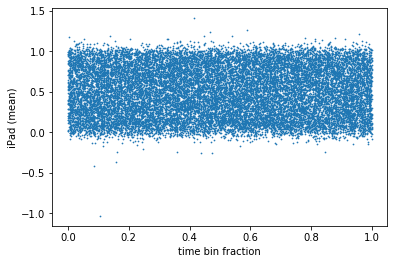

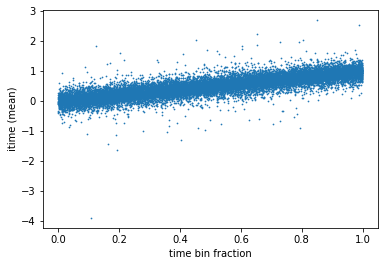

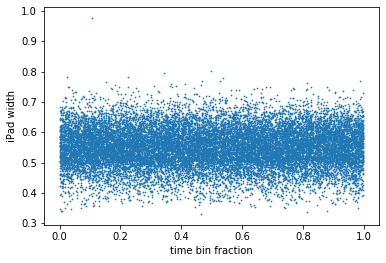

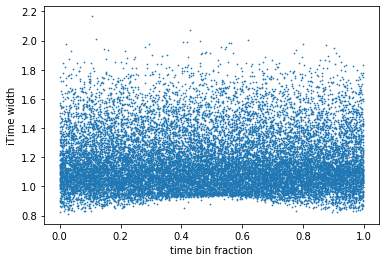

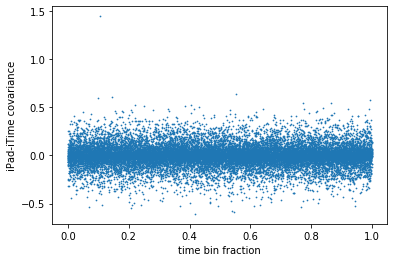

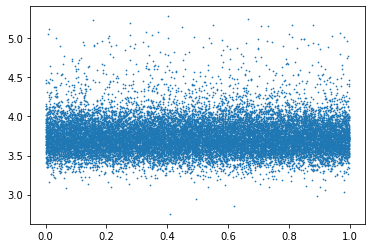

In [60]:
plt.figure();
plt.scatter(features[:,2] % 1, metric[:,0] + pad_range[0], s=0.5);
plt.xlabel("time bin fraction")
plt.ylabel("iPad (mean)")

plt.figure();
plt.scatter(features[:,2] % 1, metric[:,1] + time_range[0], s=0.5);
plt.xlabel('time bin fraction')
plt.ylabel("itime (mean)");

plt.figure();
plt.scatter(features[:,2] % 1, metric[:,2]**0.5, s=0.5);
plt.xlabel("time bin fraction")
plt.ylabel("iPad width")

plt.figure();
plt.scatter(features[:,2] % 1, metric[:,3]**0.5, s=0.5);
plt.xlabel("time bin fraction")
plt.ylabel("iTime width")


plt.figure();
plt.scatter(features[:,2] % 1, metric[:,4], s=0.5);
plt.xlabel("time bin fraction")
plt.ylabel("iPad-iTime covariance")


plt.figure();
plt.scatter(features[:,2] % 1, np.log10(metric[:,5]), s=0.5);

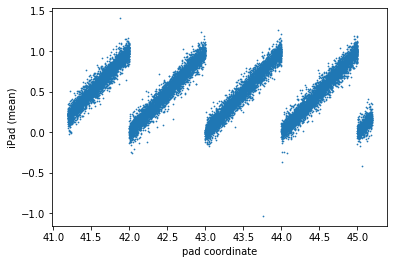

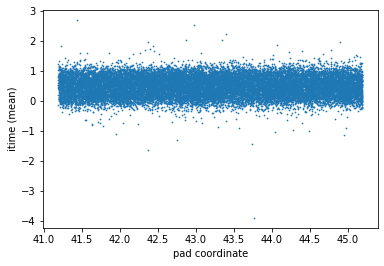

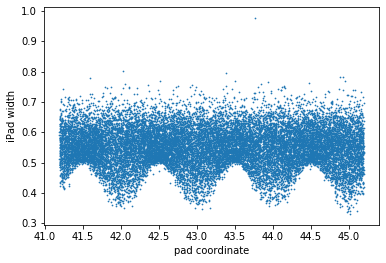

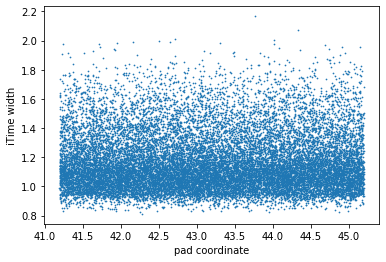

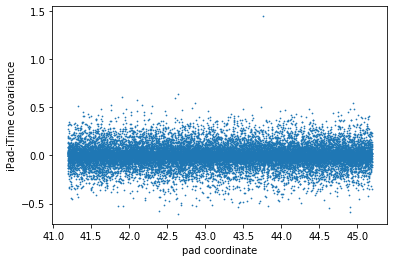

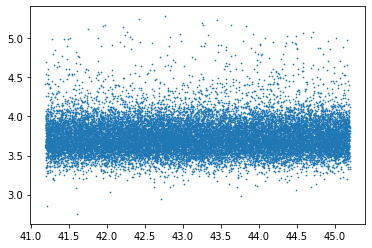

In [61]:
plt.figure();
plt.scatter(features[:,3], metric[:,0] + pad_range[0], s=0.5);
plt.xlabel("pad coordinate")
plt.ylabel("iPad (mean)")

plt.figure();
plt.scatter(features[:,3], metric[:,1] + time_range[0], s=0.5);
plt.xlabel('pad coordinate')
plt.ylabel("itime (mean)");

plt.figure();
plt.scatter(features[:,3], metric[:,2]**0.5, s=0.5);
plt.xlabel("pad coordinate")
plt.ylabel("iPad width")

plt.figure();
plt.scatter(features[:,3], metric[:,3]**0.5, s=0.5);
plt.xlabel("pad coordinate")
plt.ylabel("iTime width")


plt.figure();
plt.scatter(features[:,3], metric[:,4], s=0.5);
plt.xlabel("pad coordinate")
plt.ylabel("iPad-iTime covariance")


plt.figure();
plt.scatter(features[:,3], np.log10(metric[:,5]), s=0.5);

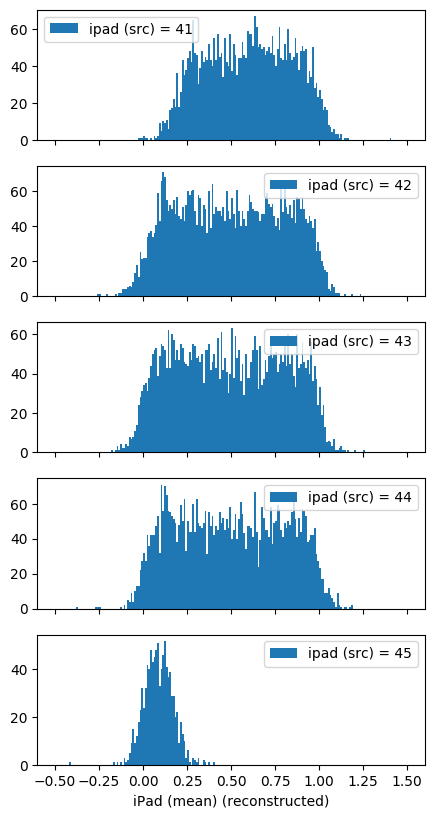

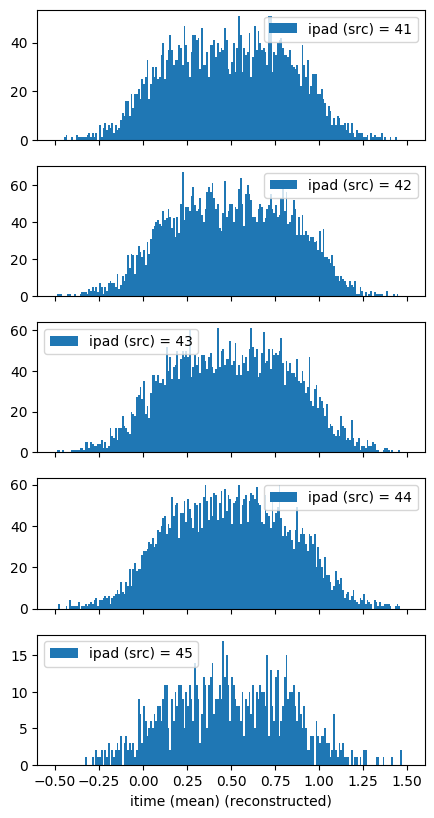

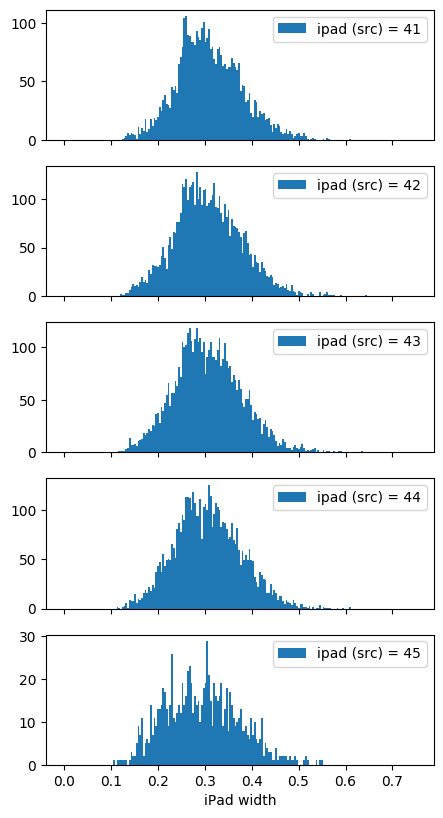

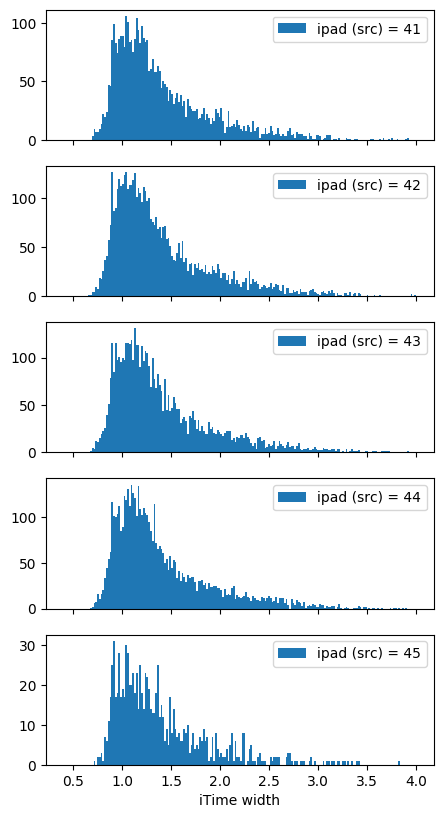

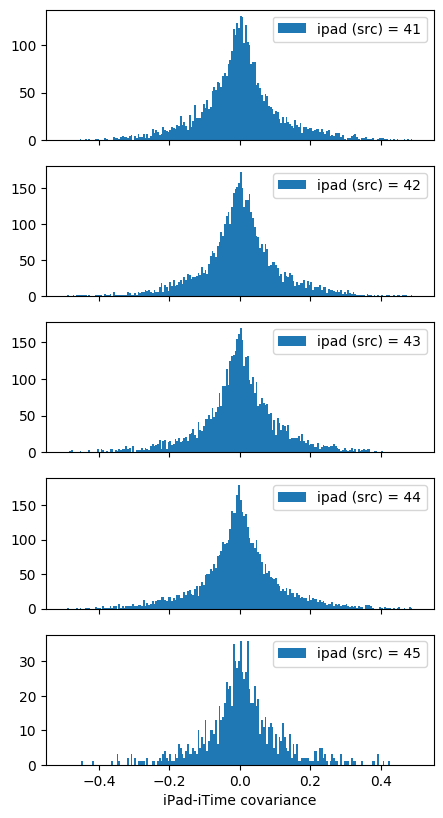

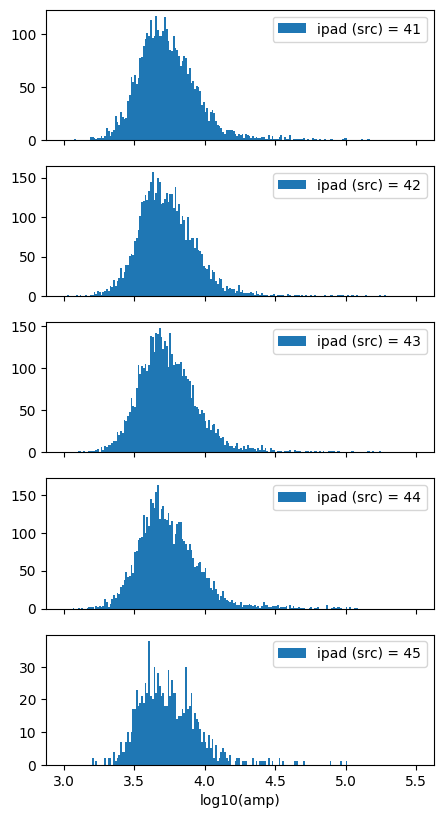

In [87]:
# plt.figure();
# plt.scatter(features[:,3].astype(int), metric[:,0] + pad_range[0], s=0.5);
# plt.xlabel("pad coordinate")
# plt.ylabel("iPad (mean)")

fig, axx = plt.subplots(dpi=100, figsize=(5, 10), nrows=5, ncols=1, sharex=True)
for ii, (ii_ipad, ax) in enumerate(zip(range(41, 46), axx)):
    ax.hist(metric[:,0][features[:,3].astype(int) == ii_ipad] + pad_range[0],
            bins=np.linspace(-0.5, 1.5, 201), alpha=1, label=f'ipad (src) = {ii_ipad}')
    ax.legend()
plt.xlabel("iPad (mean) (reconstructed)");

# plt.figure();
# plt.scatter(features[:,3].astype(int), metric[:,1] + time_range[0], s=0.5);
# plt.xlabel('pad coordinate')
# plt.ylabel("itime (mean)");

fig, axx = plt.subplots(dpi=100, figsize=(5, 10), nrows=5, ncols=1, sharex=True)
for ii, (ii_ipad, ax) in enumerate(zip(range(41, 46), axx)):
    ax.hist(metric[:,1][features[:,3].astype(int) == ii_ipad] + time_range[0],
            bins=np.linspace(-0.5, 1.5, 201), alpha=1, label=f'ipad (src) = {ii_ipad}')
    ax.legend()
plt.xlabel("itime (mean) (reconstructed)");

# plt.figure();
# plt.scatter(features[:,3].astype(int), metric[:,2]**0.5, s=0.5);
# plt.xlabel("pad coordinate")
# plt.ylabel("iPad width")

fig, axx = plt.subplots(dpi=100, figsize=(5, 10), nrows=5, ncols=1, sharex=True)
for ii, (ii_ipad, ax) in enumerate(zip(range(41, 46), axx)):
    ax.hist(metric[:,2][features[:,3].astype(int) == ii_ipad],
            bins=np.linspace(-0., 0.75, 201), alpha=1, label=f'ipad (src) = {ii_ipad}')
    ax.legend()
plt.xlabel("iPad width");

# plt.figure();
# plt.scatter(features[:,3].astype(int), metric[:,3]**0.5, s=0.5);
# plt.xlabel("pad coordinate")
# plt.ylabel("iTime width")

fig, axx = plt.subplots(dpi=100, figsize=(5, 10), nrows=5, ncols=1, sharex=True)
for ii, (ii_ipad, ax) in enumerate(zip(range(41, 46), axx)):
    ax.hist(metric[:,3][features[:,3].astype(int) == ii_ipad],
            bins=np.linspace(0.4, 4., 201), alpha=1, label=f'ipad (src) = {ii_ipad}')
    ax.legend()
plt.xlabel("iTime width");

# plt.figure();
# plt.scatter(features[:,3].astype(int), metric[:,4], s=0.5);
# plt.xlabel("pad coordinate")
# plt.ylabel("iPad-iTime covariance")

fig, axx = plt.subplots(dpi=100, figsize=(5, 10), nrows=5, ncols=1, sharex=True)
for ii, (ii_ipad, ax) in enumerate(zip(range(41, 46), axx)):
    ax.hist(metric[:,4][features[:,3].astype(int) == ii_ipad],
            bins=np.linspace(-0.5, 0.5, 201), alpha=1, label=f'ipad (src) = {ii_ipad}')
    ax.legend()
plt.xlabel("iPad-iTime covariance");

# plt.figure();
# plt.scatter(features[:,3].astype(int), np.log10(metric[:,5]), s=0.5);

fig, axx = plt.subplots(dpi=100, figsize=(5, 10), nrows=5, ncols=1, sharex=True)
for ii, (ii_ipad, ax) in enumerate(zip(range(41, 46), axx)):
    ax.hist(np.log10(metric[:,5][features[:,3].astype(int) == ii_ipad]),
            bins=np.linspace(3, 5.5, 201), alpha=1, label=f'ipad (src) = {ii_ipad}')
    ax.legend()
plt.xlabel("log10(amp)");

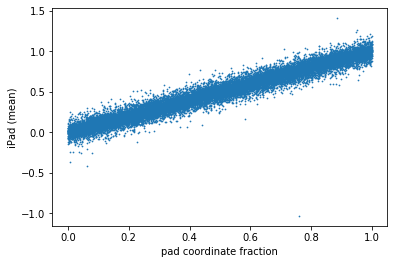

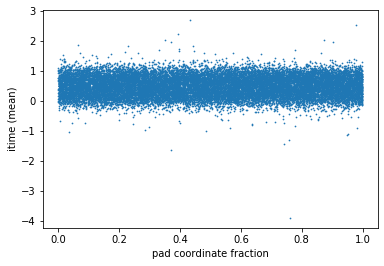

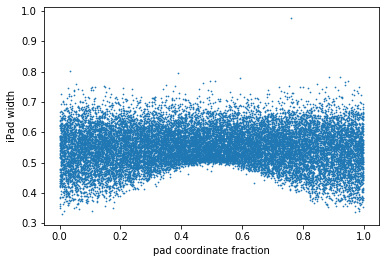

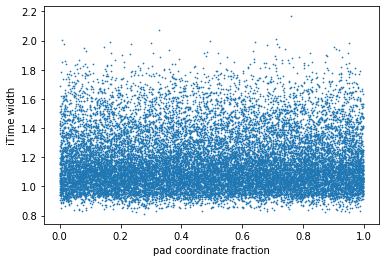

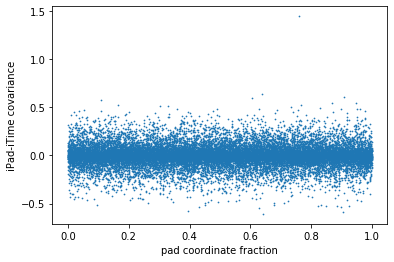

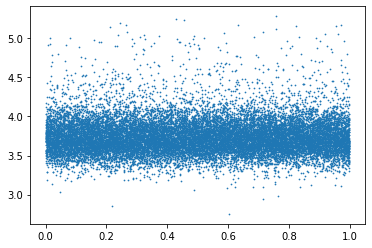

In [88]:
plt.figure();
plt.scatter(features[:,3] % 1, metric[:,0] + pad_range[0], s=0.5);
plt.xlabel("pad coordinate fraction")
plt.ylabel("iPad (mean)")

plt.figure();
plt.scatter(features[:,3] % 1, metric[:,1] + time_range[0], s=0.5);
plt.xlabel('pad coordinate fraction')
plt.ylabel("itime (mean)");

plt.figure();
plt.scatter(features[:,3] % 1, metric[:,2]**0.5, s=0.5);
plt.xlabel("pad coordinate fraction")
plt.ylabel("iPad width")

plt.figure();
plt.scatter(features[:,3] % 1, metric[:,3]**0.5, s=0.5);
plt.xlabel("pad coordinate fraction")
plt.ylabel("iTime width")


plt.figure();
plt.scatter(features[:,3] % 1, metric[:,4], s=0.5);
plt.xlabel("pad coordinate fraction")
plt.ylabel("iPad-iTime covariance")


plt.figure();
plt.scatter(features[:,3] % 1, np.log10(metric[:,5]), s=0.5);

In [28]:
features

array([[-13.377, -53.664,  35.936],
       [ 19.927, -19.677, 265.357],
       [ 14.328,  -6.482,  68.385],
       ...,
       [  7.38 , -49.191,  97.898],
       [-16.193,   7.536,  88.851],
       [ -9.   , -37.421, 151.98 ]])

-------------------------------------------
# *Old code*

In [25]:
from plotting import _bootstrap_error

In [68]:
def plot_trend(x, y, bins=100, window_size=20, **kwargs):
    if 'alpha' not in kwargs:
        kwargs['alpha'] = 0.7

    assert x.ndim == 1
    assert y.ndim == 1
    if isinstance(bins, int):
        bins = np.linspace(np.min(x), np.max(x), bins + 1)
    sel = (x >= bins[0])
    x, y = x[sel], y[sel]
    cats = (x[:,np.newaxis] < bins[np.newaxis,1:]).argmax(axis=1)
    
    def stats(arr):
        return (
            arr.mean(),
            arr.std() / (len(arr) - 1)**0.5,
            arr.std(),
            _bootstrap_error(arr, np.std)
        )
    
    mean, mean_err, std, std_err, bin_centers = np.array([
        stats(
            y[(cats >= left) & (cats < right)]
        ) + ((bins[left] + bins[right]) / 2,) for left, right in zip(
            range(len(bins) - window_size),
            range(window_size, len(bins))
        )
    ]).T
    mean_p_std_err = (mean_err**2 + std_err**2)**0.5
    plt.fill_between(bin_centers, mean - mean_err, mean + mean_err, **kwargs)
    kwargs['alpha'] *= 0.5
    plt.fill_between(bin_centers, mean - std - mean_p_std_err, mean - std + mean_p_std_err, **kwargs)
    plt.fill_between(bin_centers, mean + std - mean_p_std_err, mean + std + mean_p_std_err, **kwargs)
    kwargs['alpha'] *= 0.25
    plt.fill_between(bin_centers, mean - std + mean_p_std_err, mean + std - mean_p_std_err, **kwargs)


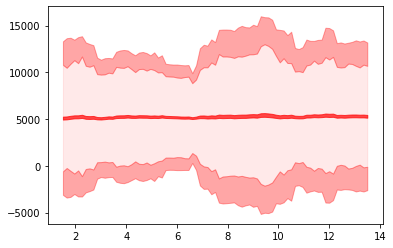

In [75]:
plot_trend(features[:,0], metric[:,5], color='red')

In [29]:
data_scaled = np.log10(1 + data).astype('float32')
X_train, X_test = train_test_split(data_scaled, test_size=0.25, random_state=42)

# GAN

In [30]:
LATENT_DIM = 32
activation = tf.keras.activations.elu
dropout_rate = 0.2

generator = tf.keras.Sequential([
  tf.keras.layers.Dense(units=64, activation=activation, input_shape=(LATENT_DIM,)),

  tf.keras.layers.Dense(units=480, activation=activation, input_shape=(LATENT_DIM,)),
  tf.keras.layers.Reshape((3, 4, 40)),

  tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding='same', activation=activation),
  tf.keras.layers.UpSampling2D(), # 6x8

  tf.keras.layers.Conv2D(filters=16, kernel_size=3, padding='same', activation=activation),
  tf.keras.layers.UpSampling2D(), # 12x16

  tf.keras.layers.Conv2D(filters=8, kernel_size=3, padding='same', activation=activation),
  tf.keras.layers.Conv2D(filters=4, kernel_size=(3, 2), padding='valid', activation=activation),

  tf.keras.layers.Conv2D(filters=1, kernel_size=1, padding='valid', activation=activation),

  tf.keras.layers.Reshape((10, 15)),
], name='generator')

discriminator = tf.keras.Sequential([
  tf.keras.layers.Reshape((10, 15, 1), input_shape=(10, 15)),

  tf.keras.layers.Conv2D(filters=16, kernel_size=3, padding='same', activation=activation),
  tf.keras.layers.Dropout(dropout_rate),

  tf.keras.layers.MaxPool2D(padding='same'), # 5x8

  tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding='same', activation=activation),
  tf.keras.layers.Dropout(dropout_rate),

  tf.keras.layers.MaxPool2D(padding='same'), # 3x4

  tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding='valid', activation=activation), # 1x2
  tf.keras.layers.Dropout(dropout_rate),

  tf.keras.layers.Reshape((128,)),

  tf.keras.layers.Dense(units=128, activation=activation),
  tf.keras.layers.Dropout(dropout_rate),

  tf.keras.layers.Dense(units=1, activation=activation),
], name='discriminator')

In [31]:
def plot_val(size=(10, 5)):
  fakes = make_fake([0]*250).numpy()

  plt.figure(figsize=size)

  plt.subplot(3, 2, 1)
  plt.plot(fakes.mean(axis=(0, 1)), label='fake')
  plt.plot(X_test.mean(axis=(0, 1)), label='real')
  plt.legend()
  plt.title('Time profile, mean')

  plt.subplot(3, 2, 2)
  plt.plot(fakes.mean(axis=(0, 2)), label='fake')
  plt.plot(X_test.mean(axis=(0, 2)), label='real')
  plt.legend()
  plt.title('ipad profile, mean')

  plt.subplot(3, 2, 3)
  plt.plot(fakes.max(axis=(0, 1)), label='fake')
  plt.plot(X_test.max(axis=(0, 1)), label='real')
  plt.legend()
  plt.title('Time profile, max')

  plt.subplot(3, 2, 4)
  plt.plot(fakes.max(axis=(0, 2)), label='fake')
  plt.plot(X_test.max(axis=(0, 2)), label='real')
  plt.legend()
  plt.title('ipad profile, max')

  plt.subplot(3, 2, 5)
  plt.plot(np.median(fakes, axis=(0, 1)), label='fake')
  plt.plot(np.median(X_test, axis=(0, 1)), label='real')
  plt.legend()
  plt.title('Time profile, median')

  plt.subplot(3, 2, 6)
  plt.plot(np.median(fakes, axis=(0, 2)), label='fake')
  plt.plot(np.median(X_test, axis=(0, 2)), label='real')
  plt.legend()
  plt.title('ipad profile, median')

  plt.tight_layout()
  plt.show();

In [32]:
import sys
import time

In [33]:
current_path

PosixPath('/home/amaevskiy/TPC/TPC-FastSim/notebooks')

In [35]:
model_path = current_path.joinpath('saved_models', 'model_{}_{}_{}'.format(*time.localtime()[:3]))
model_path.mkdir(parents=True)

Losses (disc, gen): -0.6227440237998962, 0.6368598341941833


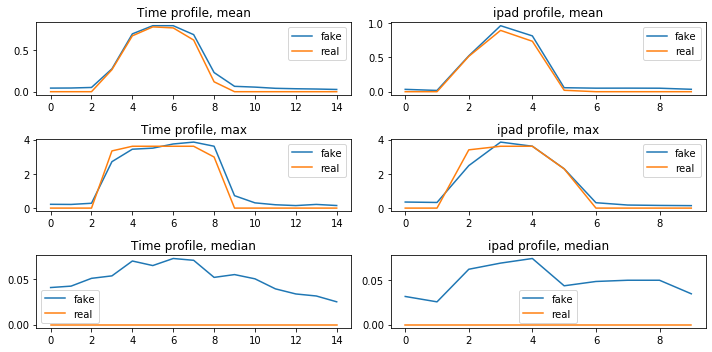

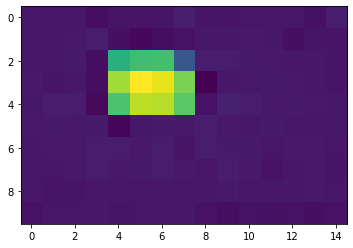

In [36]:
NUM_EPOCHS = 51
BATCH_SIZE = 32
SAVE_FREQ = 25

NUM_DISC_UPDATES = 2

GP_LAMBDA = 10.

disc_opt = tf.optimizers.RMSprop()
gen_opt = tf.optimizers.RMSprop()

def make_fake(batch):
  return generator(
      np.random.normal(size=(len(batch), LATENT_DIM)).astype('float32')
  )

def disc_loss(d_real, d_fake):
  return tf.reduce_mean(d_fake - d_real)

def gen_loss(d_real, d_fake):
  return tf.reduce_mean(d_real - d_fake)

def gradient_penalty(real, fake):
  alpha = tf.random.uniform(shape=[len(real), 1, 1])
  interpolates = alpha * real + (1 - alpha) * fake
  with tf.GradientTape() as t:
    t.watch(interpolates)
    d_int = discriminator(interpolates)
  grads = tf.reshape(t.gradient(d_int, interpolates), [len(real), -1])
  return tf.reduce_mean(tf.maximum(tf.norm(grads, axis=-1) - 1, 0)**2)
  
def disc_step(batch):
  batch = tf.convert_to_tensor(batch)
  fake = make_fake(batch)

  with tf.GradientTape() as t:
    d_real = discriminator(batch)
    d_fake = discriminator(fake)
    d_loss = disc_loss(d_real, d_fake) + GP_LAMBDA * gradient_penalty(batch, fake)
  g_loss = gen_loss(d_real, d_fake)
  loss_vals = d_loss.numpy(), g_loss.numpy()

  grads = t.gradient(d_loss, discriminator.trainable_variables)
  disc_opt.apply_gradients(zip(grads, discriminator.trainable_variables))
  return loss_vals

def gen_step(batch):
  batch = tf.convert_to_tensor(batch)
  d_real = discriminator(batch)

  with tf.GradientTape() as t:
    fake = make_fake(batch)
    d_fake = discriminator(fake)
    g_loss = gen_loss(d_real, d_fake)
  d_loss = disc_loss(d_real, d_fake) + GP_LAMBDA * gradient_penalty(batch, fake)
  loss_vals = d_loss.numpy(), g_loss.numpy()

  grads = t.gradient(g_loss, generator.trainable_variables)
  gen_opt.apply_gradients(zip(grads, generator.trainable_variables))
  return loss_vals

sequence = iter(cycle([disc_step for _ in range(NUM_DISC_UPDATES)] + [gen_step]))

losses_train = []
losses_test = []
for i_epoch in range(NUM_EPOCHS):
  if i_epoch % SAVE_FREQ == 0:
    generator.save(str(model_path.joinpath('generator_{:04d}.h5'.format(i_epoch))),
                   save_format='h5')
    discriminator.save(str(model_path.joinpath('discriminator_{:04d}.h5'.format(i_epoch))),
                       save_format='h5')
    

  print("Working on epoch #{}".format(i_epoch))
  sys.stdout.flush()
  shuffle_ids = np.random.permutation(len(X_train))
  for i_sample in trange(0, len(X_train), BATCH_SIZE):
    batch = X_train[shuffle_ids][i_sample:i_sample+BATCH_SIZE]
    losses = next(sequence)(batch)
    losses_train.append((i_epoch, i_sample, *losses))
  
  losses = np.array([0, 0], dtype='float32')
  for i_sample in range(0, len(X_test), BATCH_SIZE):
    batch = X_test[i_sample:i_sample+BATCH_SIZE]
    fake = make_fake(batch)
    d_real = discriminator(batch)
    d_fake = discriminator(fake)
    losses += np.array([
      (disc_loss(d_real, d_fake) + GP_LAMBDA * gradient_penalty(batch, fake)).numpy(),
      gen_loss(d_real, d_fake).numpy()
    ], dtype='float32') * len(batch)
  losses /= len(X_test)

  losses_test.append((i_epoch, *losses))
  clear_output(True)
  print("Losses (disc, gen): {}, {}".format(*losses))

  plot_val()
  plt.imshow(make_fake([0]).numpy()[::-1].squeeze())
  plt.show()

In [37]:
generator.save(str(model_path.joinpath('generator_{:04d}.h5'.format(i_epoch + 1))),
                save_format='h5')
discriminator.save(str(model_path.joinpath('discriminator_{:04d}.h5'.format(i_epoch + 1))),
                    save_format='h5')

In [38]:
losses_train = pd.DataFrame(losses_train, columns=['epoch', 'sample', 'disc_loss', 'gen_loss'])
losses_test  = pd.DataFrame(losses_test , columns=['epoch',           'disc_loss', 'gen_loss'])

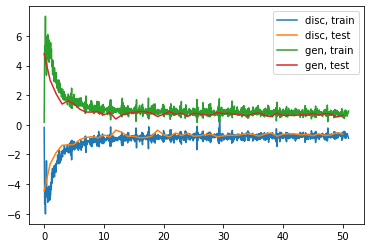

In [39]:
plt.plot(losses_train.epoch + losses_train['sample'] / len(X_train), losses_train.disc_loss, label='disc, train')
plt.plot(losses_test .epoch                                        , losses_test .disc_loss, label='disc, test' )
plt.plot(losses_train.epoch + losses_train['sample'] / len(X_train), losses_train.gen_loss , label='gen, train')
plt.plot(losses_test .epoch                                        , losses_test .gen_loss , label='gen, test' )
plt.legend();

In [40]:
def gaussian_fit(img):
  assert img.ndim == 2
  assert (img >= 0).all()
  assert (img > 0).any()
  img_n = img / img.sum()

  mu = np.fromfunction(
      lambda i, j: (img_n[np.newaxis,...] * np.stack([i, j])).sum(axis=(1, 2)),
      shape=img.shape
  )
  cov = np.fromfunction(
      lambda i, j: (
          (img_n[np.newaxis,...] * np.stack([i * i, j * i, i * j, j * j])).sum(axis=(1, 2))
      ) - np.stack([mu[0]**2, mu[0]*mu[1], mu[0]*mu[1], mu[1]**2]),
      shape=img.shape
  ).reshape(2, 2)
  return mu, cov

def get_val_metric_single(img):
  assert img.ndim == 2

  img = np.where(img < 0, 0, img)

  mu, cov = gaussian_fit(img)

  return np.array((*mu, *cov.diagonal(), cov[0, 1], img.sum()))

get_val_metric = np.vectorize(get_val_metric_single, signature='(m,n)->(k)')

fake = make_fake([0] * len(X_test))
metric_real = get_val_metric(X_test)
metric_fake = get_val_metric(fake)

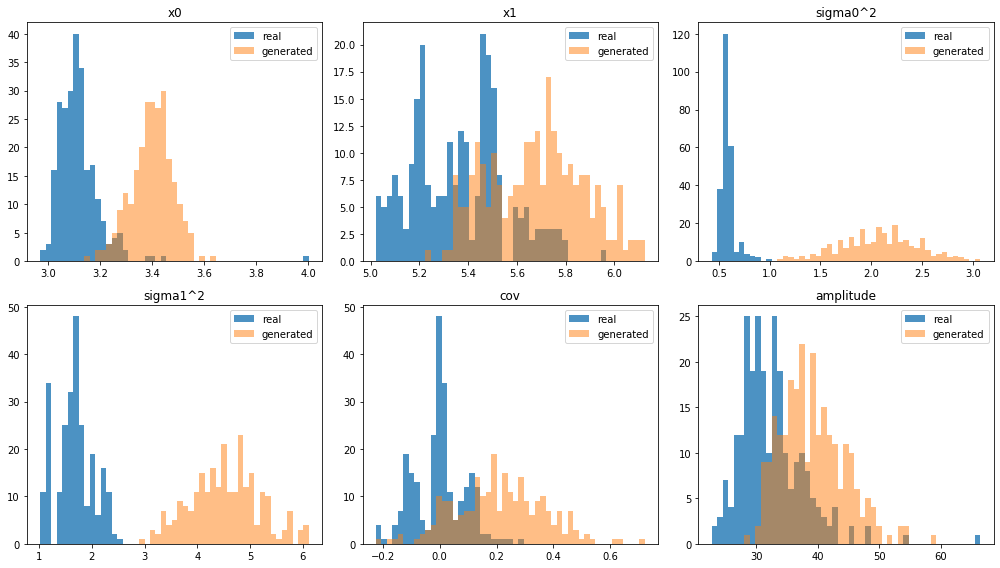

In [41]:
plt.figure(figsize=(14, 8))
labels = ['x0', 'x1', 'sigma0^2', 'sigma1^2', 'cov', 'amplitude']
for i in range(6):
  plt.subplot(2, 3, i + 1)
  r = metric_real[:,i]
  f = metric_fake[:,i]
  bins = np.linspace(
      min(r.min(), f.min()),
      max(r.max(), f.max()),
      50
  )

  plt.hist(r, bins=bins, label='real'     , alpha=0.8)
  plt.hist(f, bins=bins, label='generated', alpha=0.5)
  plt.legend()
  plt.title(labels[i])
plt.tight_layout()
plt.show();

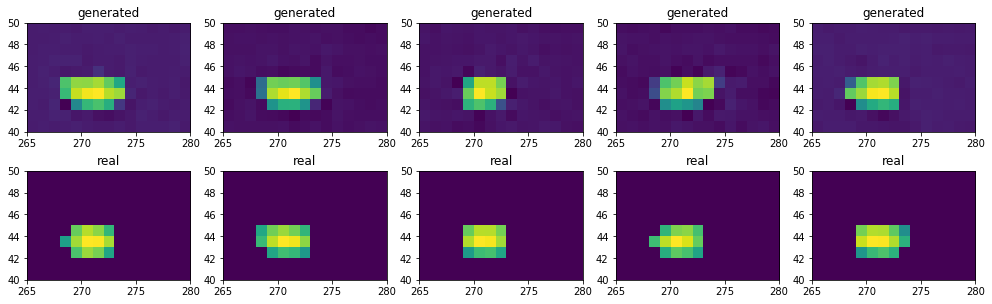

In [42]:
plt.figure(figsize=(17, 5))
for i in range(5):
  plt.subplot(2, 5, i + 1)
  plt.imshow(fake[i,::-1], extent=(*time_range, *pad_range))
  plt.title('generated')

for i in range(5):
  plt.subplot(2, 5, i + 1 + 5)
  plt.imshow(X_test[i,::-1], extent=(*time_range, *pad_range))
  plt.title('real')
plt.show();

In [43]:
generated_scaled = make_fake([0] * 1000).numpy()
generated = 10**generated_scaled - 1.

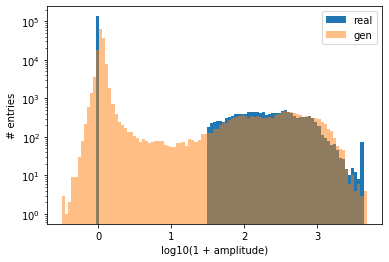

In [44]:
bins = np.linspace(generated_scaled.min(), generated_scaled.max(), 100)
plt.hist(data_scaled     .flatten(), label='real', bins=bins)
plt.hist(generated_scaled.flatten(), label='gen' , bins=bins, alpha=0.5)
plt.yscale('log')
plt.xlabel('log10(1 + amplitude)')
plt.ylabel('# entries')
plt.legend();

In [ ]:
generated.shape

(1000, 10, 15)

In [45]:
with open(str(model_path.joinpath('generated.dat')), 'w') as f:
  for event in generated:
    for ipad, time_distr in enumerate(event, pad_range[0]):
      for itime, amp in enumerate(time_distr, time_range[0]):
        if amp < 30:
          continue
        f.write("{:3d}{:4d}{:7.1f} ".format(ipad, itime, amp))
    f.write('\n')